In [1]:
import sys
sys.path.append('..')

from swarm_algo.aco import AntColonyOptimizer
from search_algo.astar import AStar, TSPProblem as AStarTSPProblem
from search_algo.hill_climbing import HillClimbing, TSPProblem as HillClimbingTSPProblem
from search_algo.genetic import GeneticAlgorithm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import warnings
from typing import List, Tuple, Dict
import pandas as pd


warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 10

## 1. Tải dữ liệu kiểm tra TSP

In [2]:
import os
import glob

def load_distance_matrix(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    matrix = []
    for line in lines:
        row = [int(x) for x in line.strip().split()]
        if row:
            matrix.append(row)
    
    return np.array(matrix)

def load_optimal_solution(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    solution = []
    for line in lines:
        line = line.strip()
        if line:
            solution.append(int(line) - 1)
    
    return solution[:-1] if solution else []

def calculate_tour_distance_from_matrix(tour, distance_matrix):
    from_cities = np.array(tour)
    to_cities = np.array(tour[1:] + [tour[0]])
    return np.sum(distance_matrix[from_cities, to_cities])

def load_all_test_cases():
    test_cases = {}
    data_dir = '../data/tsp'
    
    distance_files = sorted(glob.glob(os.path.join(data_dir, '*_d.txt')))
    
    for dist_file in distance_files:
        base_name = os.path.basename(dist_file).replace('_d.txt', '')
        sol_file = dist_file.replace('_d.txt', '_s.txt')
        
        distance_matrix = load_distance_matrix(dist_file)
        optimal_solution = load_optimal_solution(sol_file) if os.path.exists(sol_file) else None
        
        if optimal_solution:
            optimal_distance = calculate_tour_distance_from_matrix(optimal_solution, distance_matrix)
        else:
            optimal_distance = None
        
        test_cases[base_name] = {
            'distance_matrix': distance_matrix,
            'optimal_solution': optimal_solution,
            'optimal_distance': optimal_distance,
            'n_cities': len(distance_matrix)
        }
    
    return test_cases

test_cases = load_all_test_cases()


## 2. Hàm chạy thuật toán

In [3]:
def run_aco(distance_matrix, num_runs=5):
    n_cities = len(distance_matrix)
    results = []
    
    for _ in range(num_runs):
        cities_coords = np.random.rand(n_cities, 2) * 100
        
        aco = AntColonyOptimizer(
            colony=cities_coords,
            num_ant=20,
            iter=100,
            alpha=1.0,
            beta=2.0,
            rho=0.5,
            Q=100
        )
        
        aco.distance_matrix = distance_matrix
        aco.zeta = np.where(distance_matrix > 0, 1.0 / distance_matrix, 0)
        
        start_time = time.time()
        tour, distance = aco.run(verbose=False)
        elapsed_time = time.time() - start_time
        
        results.append({
            'tour': tour,
            'distance': distance,
            'time': elapsed_time
        })
    
    return results

def run_astar(distance_matrix, num_runs=1):
    n_cities = len(distance_matrix)
    results = []
    
    for _ in range(num_runs):
        cities_coords = [(0, 0) for _ in range(n_cities)]
        
        astar_problem = AStarTSPProblem(cities=cities_coords, start_city=0)
        astar_problem.distances = distance_matrix.tolist()
        astar_solver = AStar(problem=astar_problem, verbose=False)
        
        start_time = time.time()
        try:
            astar_path, astar_distance = astar_solver.solve()
            elapsed_time = time.time() - start_time
            
            if astar_path is not None:
                astar_tour = [state[0] for state in astar_path[:-1]]
                results.append({
                    'tour': astar_tour,
                    'distance': astar_distance,
                    'time': elapsed_time
                })
            else:
                results.append({
                    'tour': None,
                    'distance': float('inf'),
                    'time': elapsed_time
                })
        except Exception as e:
            elapsed_time = time.time() - start_time
            results.append({
                'tour': None,
                'distance': float('inf'),
                'time': elapsed_time
            })
    
    return results

def run_hill_climbing(distance_matrix, num_runs=5):
    results = []
    
    for _ in range(num_runs):
        hc_problem = HillClimbingTSPProblem(distance_matrix=distance_matrix)
        hc_solver = HillClimbing(problem=hc_problem, max_iters=1000, variant="steepest", verbose=False)
        
        start_time = time.time()
        tour, distance, _ = hc_solver.solve()
        elapsed_time = time.time() - start_time
        
        results.append({
            'tour': tour,
            'distance': distance,
            'time': elapsed_time
        })
    
    return results

def run_genetic_algorithm(distance_matrix, num_runs=5):
    results = []
    
    for _ in range(num_runs):
        ga = TSPGeneticAlgorithm(
            cities=None,
            distance_matrix=distance_matrix,
            population_size=50,
            mutation_rate=0.1,
            elite_rate=0.2
        )
        
        start_time = time.time()
        tour, distance, _, _ = ga.run(generations=100)
        elapsed_time = time.time() - start_time
        
        results.append({
            'tour': tour,
            'distance': distance,
            'time': elapsed_time
        })
    
    return results

In [4]:
class TSPGeneticAlgorithm:
    def __init__(self, cities, distance_matrix, population_size=50, mutation_rate=0.1, elite_rate=0.2):
        self.cities = cities
        self.distance_matrix = distance_matrix
        self.n_cities = len(distance_matrix)
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.elite_rate = elite_rate
        
    def create_individual(self):
        tour = list(range(self.n_cities))
        np.random.shuffle(tour)
        return tour
    
    def calculate_fitness(self, tour):
        distance = calculate_tour_distance_from_matrix(tour, self.distance_matrix)
        return 1.0 / (1.0 + distance)
    
    def select_parents(self, population, fitness_scores):
        fitness_sum = np.sum(fitness_scores)
        selection_probs = fitness_scores / fitness_sum
        parent_indices = np.random.choice(len(population), size=2, p=selection_probs, replace=False)
        return population[parent_indices[0]], population[parent_indices[1]]
    
    def crossover(self, parent1, parent2):
        start = np.random.randint(0, self.n_cities - 1)
        end = np.random.randint(start + 1, self.n_cities)
        
        child = [-1] * self.n_cities
        child[start:end] = parent1[start:end]
        
        remaining = [city for city in parent2 if city not in child]
        idx = 0
        for i in range(self.n_cities):
            if child[i] == -1:
                child[i] = remaining[idx]
                idx += 1
        
        return child
    
    def mutate(self, tour):
        if np.random.rand() < self.mutation_rate:
            i, j = np.random.choice(self.n_cities, size=2, replace=False)
            tour[i], tour[j] = tour[j], tour[i]
        return tour
    
    def run(self, generations=100):
        population = [self.create_individual() for _ in range(self.population_size)]
        
        best_tour = None
        best_distance = float('inf')
        best_fitness_history = []
        avg_fitness_history = []
        
        for gen in range(generations):
            fitness_scores = np.array([self.calculate_fitness(ind) for ind in population])
            
            sorted_indices = np.argsort(-fitness_scores)
            population = [population[i] for i in sorted_indices]
            fitness_scores = fitness_scores[sorted_indices]
            
            current_best_tour = population[0]
            current_best_distance = calculate_tour_distance_from_matrix(current_best_tour, self.distance_matrix)
            
            if current_best_distance < best_distance:
                best_distance = current_best_distance
                best_tour = current_best_tour.copy()
            
            best_fitness_history.append(best_distance)
            avg_fitness_history.append(np.mean([calculate_tour_distance_from_matrix(t, self.distance_matrix) for t in population]))
            
            num_elites = int(self.elite_rate * self.population_size)
            next_generation = population[:num_elites]
            
            while len(next_generation) < self.population_size:
                parent1, parent2 = self.select_parents(population, fitness_scores)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                next_generation.append(child)
            
            population = next_generation
        
        return best_tour, best_distance, best_fitness_history, avg_fitness_history

## 3. Chạy tất cả thuật toán trên các bộ kiểm tra

In [5]:
all_results = {}

num_runs = 10

for test_name, test_data in test_cases.items():    
    distance_matrix = test_data['distance_matrix']
    
    all_results[test_name] = {
        'optimal_distance': test_data['optimal_distance'],
        'n_cities': test_data['n_cities']
    }
    
    print(f"  Chạy ACO ({num_runs} lần)...")
    all_results[test_name]['ACO'] = run_aco(distance_matrix, num_runs=num_runs)
    
    if test_data['n_cities'] <= 17:
        print(f"  Chạy A* ({num_runs} lần)...")
        all_results[test_name]['AStar'] = run_astar(distance_matrix, num_runs=num_runs)
    else:
        print(f"  Bỏ qua A* (quá nhiều thành phố: {test_data['n_cities']})")
        all_results[test_name]['AStar'] = []
    
    print(f"  Chạy Hill Climbing ({num_runs} lần)...")
    all_results[test_name]['HillClimbing'] = run_hill_climbing(distance_matrix, num_runs=num_runs)
    
    print(f"  Chạy Genetic Algorithm ({num_runs} lần)...")
    all_results[test_name]['GeneticAlgorithm'] = run_genetic_algorithm(distance_matrix, num_runs=num_runs)

  Chạy ACO (10 lần)...
  Chạy A* (10 lần)...
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...
  Chạy ACO (10 lần)...
  Chạy A* (10 lần)...
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...
  Chạy ACO (10 lần)...
  Bỏ qua A* (quá nhiều thành phố: 26)
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...
  Chạy ACO (10 lần)...
  Bỏ qua A* (quá nhiều thành phố: 48)
  Chạy Hill Climbing (10 lần)...
  Chạy Genetic Algorithm (10 lần)...


## 4. Tính toán thống kê (Tốt nhất, Trung bình, Tệ nhất)

In [6]:
def calculate_statistics(results_list):
    if not results_list:
        return {
            'best': float('inf'),
            'worst': float('inf'),
            'average': float('inf'),
            'std': 0,
            'avg_time': 0
        }
    
    distances = [r['distance'] for r in results_list if r['distance'] != float('inf')]
    times = [r['time'] for r in results_list]
    
    if not distances:
        return {
            'best': float('inf'),
            'worst': float('inf'),
            'average': float('inf'),
            'std': 0,
            'avg_time': np.mean(times) if times else 0
        }
    
    return {
        'best': np.min(distances),
        'worst': np.max(distances),
        'average': np.mean(distances),
        'std': np.std(distances),
        'avg_time': np.mean(times)
    }

statistics = {}

for test_name, test_results in all_results.items():
    statistics[test_name] = {
        'optimal_distance': test_results['optimal_distance'],
        'n_cities': test_results['n_cities']
    }
    
    for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
        if algo in test_results:
            statistics[test_name][algo] = calculate_statistics(test_results[algo])



for test_name in sorted(statistics.keys()):
    stats = statistics[test_name]
    
    print(f"\n{test_name} ({stats['n_cities']} thành phố) - Tối ưu: {stats['optimal_distance']}")
    print("-" * 120)
    
    data = []
    for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
        if algo in stats:
            s = stats[algo]
            gap_best = ((s['best'] - stats['optimal_distance']) / stats['optimal_distance'] * 100) if stats['optimal_distance'] else 0
            gap_avg = ((s['average'] - stats['optimal_distance']) / stats['optimal_distance'] * 100) if stats['optimal_distance'] else 0
            
            data.append({
                'Thuật toán': algo,
                'Tốt nhất': f"{s['best']:.2f}",
                'Trung bình': f"{s['average']:.2f}",
                'Tệ nhất': f"{s['worst']:.2f}",
                'Độ lệch chuẩn': f"{s['std']:.2f}",
                'Chênh lệch TB (%)': f"{gap_best:.2f}",
                'Chênh lệch TB (%)': f"{gap_avg:.2f}",
                'Thời gian TB (s)': f"{s['avg_time']:.3f}"
            })
    
    df = pd.DataFrame(data)
    print(df.to_string(index=False))


p01 (15 thành phố) - Tối ưu: 291
------------------------------------------------------------------------------------------------------------------------
      Thuật toán Tốt nhất Trung bình Tệ nhất Độ lệch chuẩn Chênh lệch TB (%) Thời gian TB (s)
             ACO   291.00     291.00  291.00          0.00              0.00            0.478
           AStar   291.00     291.00  291.00          0.00              0.00            2.569
    HillClimbing   291.00     304.40  331.00         13.15              4.60            0.004
GeneticAlgorithm   291.00     319.00  358.00         22.07              9.62            0.138

p02 (17 thành phố) - Tối ưu: 2006
------------------------------------------------------------------------------------------------------------------------
      Thuật toán Tốt nhất Trung bình Tệ nhất Độ lệch chuẩn Chênh lệch TB (%) Thời gian TB (s)
             ACO  2085.00    2100.80 2149.00         25.68              4.73            0.401
           AStar  2085.00    20

## 5. Thống kê tổng hợp trên tất cả các bộ kiểm tra

In [7]:
aggregated_stats = {}

for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
    gaps_best = []
    gaps_avg = []
    gaps_worst = []
    times = []
    
    for test_name, stats in statistics.items():
        if algo in stats and stats['optimal_distance'] is not None:
            s = stats[algo]
            if s['best'] != float('inf'):
                gaps_best.append((s['best'] - stats['optimal_distance']) / stats['optimal_distance'] * 100)
                gaps_avg.append((s['average'] - stats['optimal_distance']) / stats['optimal_distance'] * 100)
                gaps_worst.append((s['worst'] - stats['optimal_distance']) / stats['optimal_distance'] * 100)
                times.append(s['avg_time'])
    
    if gaps_best:
        aggregated_stats[algo] = {
            'gap_best_avg': np.mean(gaps_best),
            'gap_avg_avg': np.mean(gaps_avg),
            'gap_worst_avg': np.mean(gaps_worst),
            'gap_best_std': np.std(gaps_best),
            'gap_avg_std': np.std(gaps_avg),
            'gap_worst_std': np.std(gaps_worst),
            'avg_time': np.mean(times),
            'std_time': np.std(times)
        }
    else:
        aggregated_stats[algo] = None

agg_data = []
for algo in ['ACO', 'AStar', 'HillClimbing', 'GeneticAlgorithm']:
    if aggregated_stats[algo] is not None:
        s = aggregated_stats[algo]
        agg_data.append({
            'Thuật toán': algo,
            'Chênh lệch TB tốt nhất (%)': f"{s['gap_best_avg']:.2f} ± {s['gap_best_std']:.2f}",
            'Chênh lệch TB trung bình (%)': f"{s['gap_avg_avg']:.2f} ± {s['gap_avg_std']:.2f}",
            'Chênh lệch TB tệ nhất (%)': f"{s['gap_worst_avg']:.2f} ± {s['gap_worst_std']:.2f}",
            'Thời gian TB (s)': f"{s['avg_time']:.3f} ± {s['std_time']:.3f}"
        })

agg_df = pd.DataFrame(agg_data)
print(agg_df.to_string(index=False))

      Thuật toán Chênh lệch TB tốt nhất (%) Chênh lệch TB trung bình (%) Chênh lệch TB tệ nhất (%) Thời gian TB (s)
             ACO                2.38 ± 2.45                  2.98 ± 3.11               4.16 ± 4.24    0.648 ± 0.287
           AStar                1.97 ± 1.97                  1.97 ± 1.97               1.97 ± 1.97   10.962 ± 8.392
    HillClimbing                1.21 ± 1.69                  4.30 ± 0.61               9.78 ± 2.91    0.075 ± 0.108
GeneticAlgorithm              26.70 ± 30.90                41.31 ± 40.79             54.97 ± 43.60    0.150 ± 0.022


## 5.5 Convergence Analysis - Pairwise Algorithm Comparison

Tracking convergence behavior of algorithms over iterations to understand their optimization dynamics.

In [8]:
# Re-run one instance of each algorithm to get convergence data
sample_test = 'p01'
sample_distance_matrix = test_cases[sample_test]['distance_matrix']
sample_optimal = test_cases[sample_test]['optimal_distance']
n_cities_sample = test_cases[sample_test]['n_cities']

print(f"Running algorithms on {sample_test} ({n_cities_sample} cities) to track convergence...")

# 1. Hill Climbing
hc_problem = HillClimbingTSPProblem(distance_matrix=sample_distance_matrix)
hc_solver = HillClimbing(problem=hc_problem, max_iters=1000, variant="steepest", verbose=False)
hc_tour, hc_distance, hc_history = hc_solver.solve()
hc_convergence = hc_history if hc_history else [hc_distance]

# 2. A*
astar_problem = AStarTSPProblem(cities=[(0,0) for _ in range(n_cities_sample)], start_city=0)
astar_problem.distances = sample_distance_matrix.tolist()
astar_solver = AStar(problem=astar_problem, verbose=False)
astar_path, astar_distance = astar_solver.solve()
astar_convergence = [astar_distance] if astar_distance != float('inf') else []

# 3. Genetic Algorithm
ga = TSPGeneticAlgorithm(
    cities=None,
    distance_matrix=sample_distance_matrix,
    population_size=50,
    mutation_rate=0.1,
    elite_rate=0.2
)
ga_tour, ga_distance, ga_best_history, ga_avg_history = ga.run(generations=100)
ga_convergence = ga_best_history

# 4. ACO - Track convergence manually
cities_coords = np.random.rand(n_cities_sample, 2) * 100
aco = AntColonyOptimizer(
    colony=cities_coords,
    num_ant=20,
    iter=1,
    alpha=1.0,
    beta=2.0,
    rho=0.5,
    Q=100
)
aco.distance_matrix = sample_distance_matrix
aco.zeta = np.where(sample_distance_matrix > 0, 1.0 / sample_distance_matrix, 0)

aco_convergence = []
best_path = None
best_fitness = float('inf')

for iteration in range(100):
    all_paths = []
    all_ant_paths = []
    all_fitness = []
    
    for ant in range(aco.num_ant):
        # Build path using RWS
        cur_idx = np.random.randint(0, n_cities_sample)
        visitted = {cur_idx}
        path = [cur_idx]
        
        while len(visitted) < n_cities_sample:
            cur_idx = aco.RWS(cur_idx, visitted)
            if cur_idx is None:
                break
            path.append(cur_idx)
            visitted.add(cur_idx)
        
        if len(path) == n_cities_sample:
            ant_path = aco.path_to_ant_path(path)
            fit = aco.fitness(ant_path)
            all_paths.append(path)
            all_ant_paths.append(ant_path)
            all_fitness.append(fit)
            
            if fit < best_fitness:
                best_fitness = fit
                best_path = path.copy()
    
    if all_ant_paths:
        aco.update_pheromone(all_ant_paths)
    
    aco_convergence.append(best_fitness)

print(f"✓ Convergence data collected")
print(f"  - Hill Climbing: {len(hc_convergence)} iterations")
print(f"  - A*: {len(astar_convergence)} (direct solution)")
print(f"  - Genetic Algorithm: {len(ga_convergence)} generations")
print(f"  - ACO: {len(aco_convergence)} iterations")

Running algorithms on p01 (15 cities) to track convergence...
✓ Convergence data collected
  - Hill Climbing: 11 iterations
  - A*: 1 (direct solution)
  - Genetic Algorithm: 100 generations
  - ACO: 100 iterations


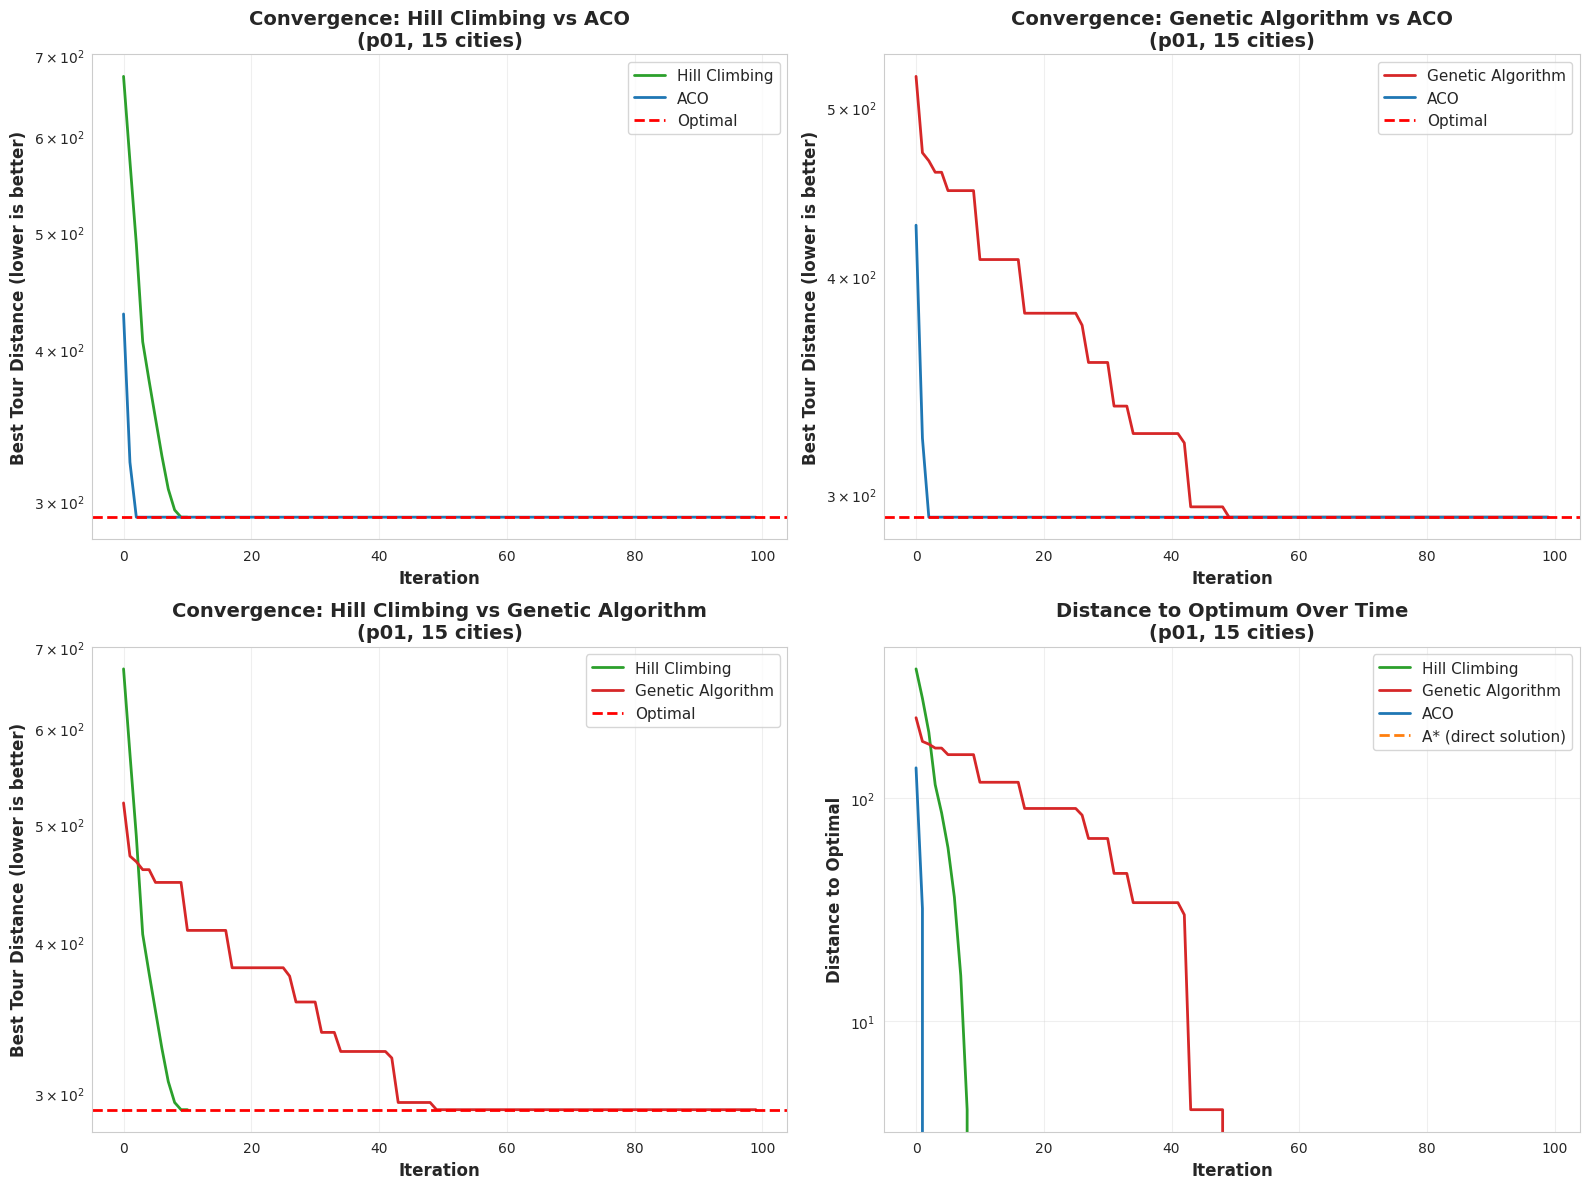


CONVERGENCE ANALYSIS SUMMARY
Problem: p01 (15 cities)
Optimal Distance: 291
--------------------------------------------------------------------------------
Hill Climbing:
  - Final: 291.00
  - Gap: 0.00%
  - Iterations: 11

Genetic Algorithm:
  - Final: 291.00
  - Gap: 0.00%
  - Generations: 100

ACO:
  - Final: 291.00
  - Gap: 0.00%
  - Iterations: 100

A* Search:
  - Distance: 291.00
  - Gap: 0.00%
  - Note: Direct solution (no iterative convergence)


In [9]:
# Convergence Comparison Plots - Style from Ackley notebook
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors_conv = {
    'HillClimbing': '#2ca02c',
    'AStar': '#ff7f0e',
    'GeneticAlgorithm': '#d62728',
    'ACO': '#1f77b4'
}

# Plot 1: Hill Climbing vs ACO
ax1 = axes[0, 0]
if len(hc_convergence) > 0:
    ax1.plot(hc_convergence, label='Hill Climbing', linewidth=2, color=colors_conv['HillClimbing'])
if len(aco_convergence) > 0:
    ax1.plot(aco_convergence, label='ACO', linewidth=2, color=colors_conv['ACO'])
ax1.axhline(y=sample_optimal, color='red', linestyle='--', label='Optimal', linewidth=2)
ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax1.set_ylabel('Best Tour Distance (lower is better)', fontsize=12, fontweight='bold')
ax1.set_title(f'Convergence: Hill Climbing vs ACO\n({sample_test}, {n_cities_sample} cities)', 
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Genetic Algorithm vs ACO
ax2 = axes[0, 1]
if len(ga_convergence) > 0:
    ax2.plot(ga_convergence, label='Genetic Algorithm', linewidth=2, color=colors_conv['GeneticAlgorithm'])
if len(aco_convergence) > 0:
    ax2.plot(aco_convergence, label='ACO', linewidth=2, color=colors_conv['ACO'])
ax2.axhline(y=sample_optimal, color='red', linestyle='--', label='Optimal', linewidth=2)
ax2.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax2.set_ylabel('Best Tour Distance (lower is better)', fontsize=12, fontweight='bold')
ax2.set_title(f'Convergence: Genetic Algorithm vs ACO\n({sample_test}, {n_cities_sample} cities)', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# Plot 3: Hill Climbing vs Genetic Algorithm
ax3 = axes[1, 0]
if len(hc_convergence) > 0:
    ax3.plot(hc_convergence, label='Hill Climbing', linewidth=2, color=colors_conv['HillClimbing'])
if len(ga_convergence) > 0:
    ax3.plot(ga_convergence, label='Genetic Algorithm', linewidth=2, color=colors_conv['GeneticAlgorithm'])
ax3.axhline(y=sample_optimal, color='red', linestyle='--', label='Optimal', linewidth=2)
ax3.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax3.set_ylabel('Best Tour Distance (lower is better)', fontsize=12, fontweight='bold')
ax3.set_title(f'Convergence: Hill Climbing vs Genetic Algorithm\n({sample_test}, {n_cities_sample} cities)', 
              fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# Plot 4: Distance to Optimum - All Algorithms
ax4 = axes[1, 1]
if len(hc_convergence) > 0:
    hc_distances = [abs(h - sample_optimal) for h in hc_convergence]
    ax4.plot(hc_distances, label='Hill Climbing', linewidth=2, color=colors_conv['HillClimbing'])
if len(ga_convergence) > 0:
    ga_distances = [abs(g - sample_optimal) for g in ga_convergence]
    ax4.plot(ga_distances, label='Genetic Algorithm', linewidth=2, color=colors_conv['GeneticAlgorithm'])
if len(aco_convergence) > 0:
    aco_distances = [abs(a - sample_optimal) for a in aco_convergence]
    ax4.plot(aco_distances, label='ACO', linewidth=2, color=colors_conv['ACO'])
if len(astar_convergence) > 0 and astar_convergence[0] != float('inf'):
    ax4.axhline(y=abs(astar_convergence[0] - sample_optimal), color=colors_conv['AStar'], 
               linestyle='--', label='A* (direct solution)', linewidth=2)

ax4.set_xlabel('Iteration', fontsize=12, fontweight='bold')
ax4.set_ylabel('Distance to Optimal', fontsize=12, fontweight='bold')
ax4.set_title(f'Distance to Optimum Over Time\n({sample_test}, {n_cities_sample} cities)', 
              fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)
ax4.set_yscale('log')

plt.tight_layout()
plt.show()

# Print convergence summary
print("\n" + "=" * 80)
print("CONVERGENCE ANALYSIS SUMMARY")
print("=" * 80)
print(f"Problem: {sample_test} ({n_cities_sample} cities)")
print(f"Optimal Distance: {sample_optimal}")
print("-" * 80)

if hc_convergence:
    print(f"Hill Climbing:")
    print(f"  - Final: {hc_convergence[-1]:.2f}")
    print(f"  - Gap: {abs(hc_convergence[-1] - sample_optimal) / sample_optimal * 100:.2f}%")
    print(f"  - Iterations: {len(hc_convergence)}")

if ga_convergence:
    print(f"\nGenetic Algorithm:")
    print(f"  - Final: {ga_convergence[-1]:.2f}")
    print(f"  - Gap: {abs(ga_convergence[-1] - sample_optimal) / sample_optimal * 100:.2f}%")
    print(f"  - Generations: {len(ga_convergence)}")

if aco_convergence:
    print(f"\nACO:")
    print(f"  - Final: {aco_convergence[-1]:.2f}")
    print(f"  - Gap: {abs(aco_convergence[-1] - sample_optimal) / sample_optimal * 100:.2f}%")
    print(f"  - Iterations: {len(aco_convergence)}")

if astar_convergence:
    print(f"\nA* Search:")
    print(f"  - Distance: {astar_convergence[0]:.2f}")
    print(f"  - Gap: {abs(astar_convergence[0] - sample_optimal) / sample_optimal * 100:.2f}%")
    print(f"  - Note: Direct solution (no iterative convergence)")
print("=" * 80)

## 6. Trực quan hóa thống kê

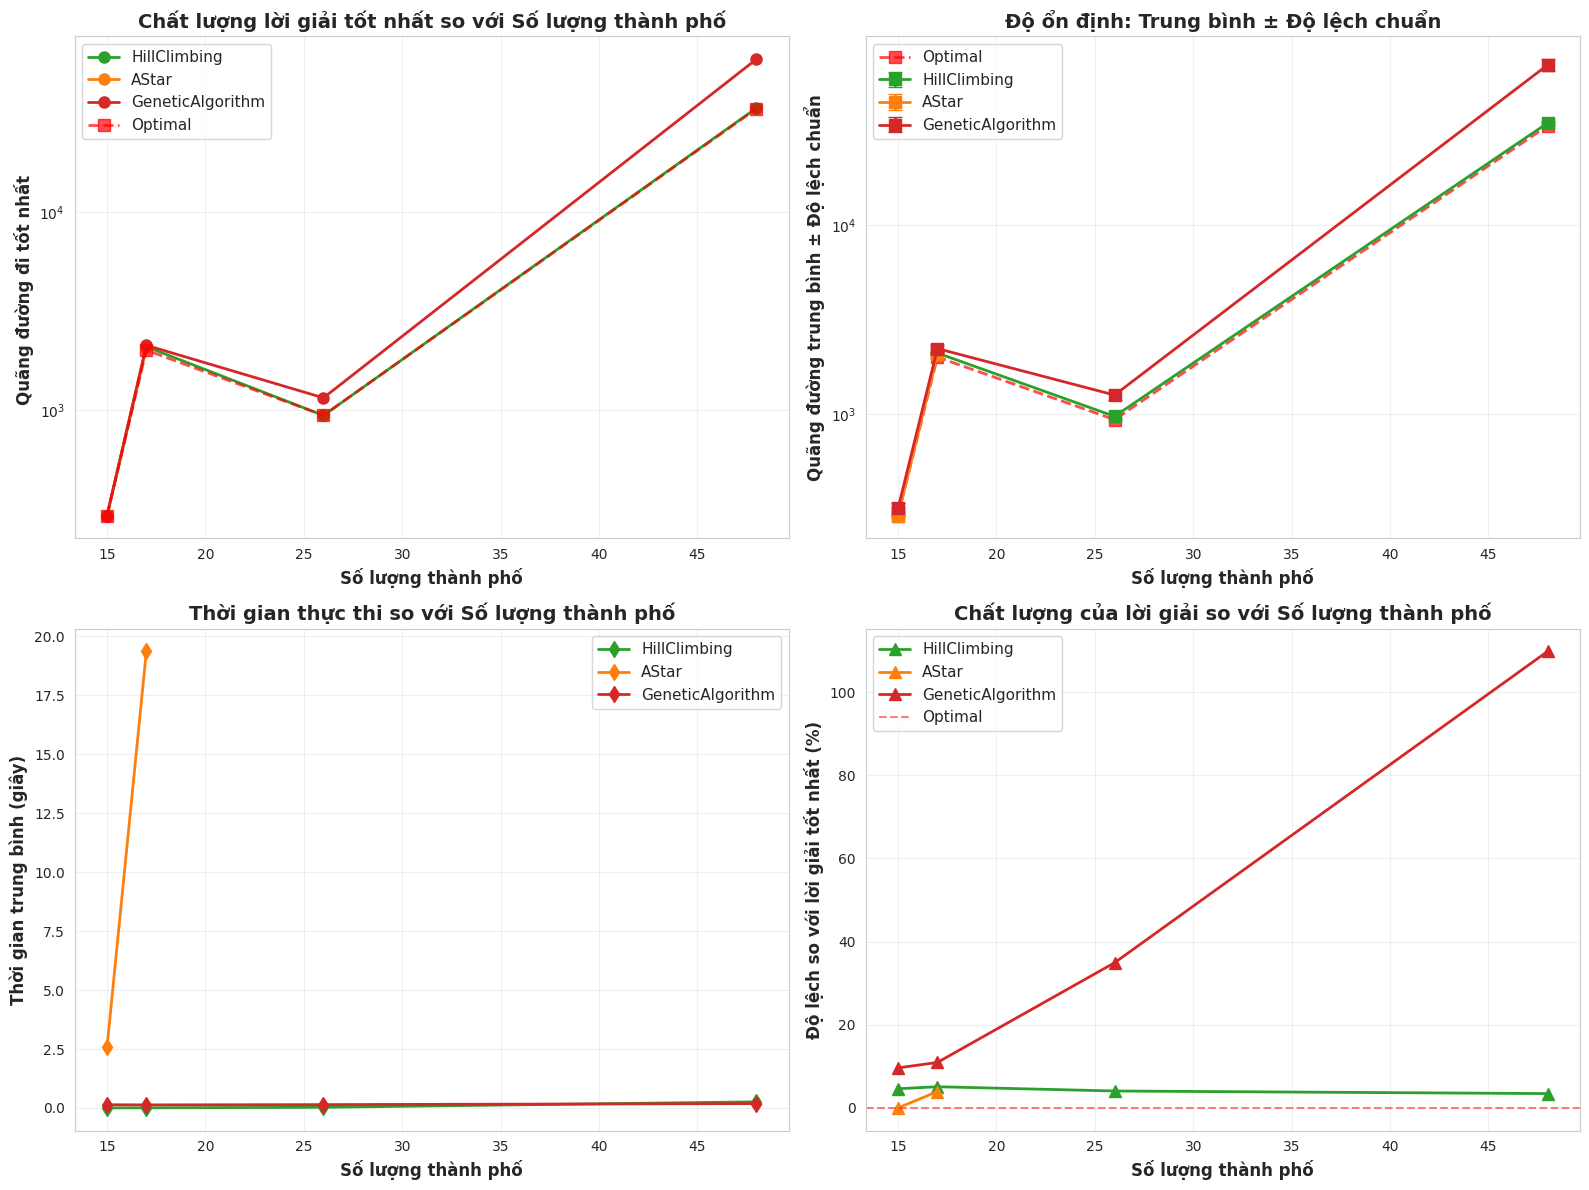

In [10]:
# Compare solution quality - Style from Ackley notebook
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

test_names = sorted(statistics.keys())
algorithms = ['HillClimbing', 'AStar', 'GeneticAlgorithm']
colors = {'ACO': '#1f77b4', 'AStar': '#ff7f0e', 'HillClimbing': '#2ca02c', 'GeneticAlgorithm': '#d62728'}

# Plot 1: Best Value vs Problem Size
ax1 = axes[0, 0]
for algo in algorithms:
    best_vals = []
    problem_sizes = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['best'] != float('inf'):
            s = statistics[test_name][algo]
            best_vals.append(s['best'])
            problem_sizes.append(statistics[test_name]['n_cities'])
    
    if best_vals:
        ax1.plot(problem_sizes, best_vals, marker='o', label=algo, linewidth=2, markersize=8, color=colors[algo])

# Add optimal values
optimal_vals = []
problem_sizes_opt = []
for test_name in test_names:
    if statistics[test_name]['optimal_distance']:
        optimal_vals.append(statistics[test_name]['optimal_distance'])
        problem_sizes_opt.append(statistics[test_name]['n_cities'])

ax1.plot(problem_sizes_opt, optimal_vals, marker='s', linestyle='--', color='red', 
         linewidth=2, markersize=8, label='Optimal', alpha=0.7)

ax1.set_xlabel('Số lượng thành phố', fontsize=12, fontweight='bold')
ax1.set_ylabel('Quãng đường đi tốt nhất ', fontsize=12, fontweight='bold')
ax1.set_title('Chất lượng lời giải tốt nhất so với Số lượng thành phố', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Mean Value with Error Bars
ax2 = axes[0, 1]
for algo in algorithms:
    mean_vals = []
    std_vals = []
    problem_sizes = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['average'] != float('inf'):
            s = statistics[test_name][algo]
            mean_vals.append(s['average'])
            std_vals.append(s['std'])
            problem_sizes.append(statistics[test_name]['n_cities'])
    
    if mean_vals:
        ax2.errorbar(problem_sizes, mean_vals, yerr=std_vals, marker='s', label=algo, 
                    linewidth=2, markersize=8, capsize=5, color=colors[algo])

ax2.plot(problem_sizes_opt, optimal_vals, marker='s', linestyle='--', color='red', 
         linewidth=2, markersize=8, label='Optimal', alpha=0.7)

ax2.set_xlabel('Số lượng thành phố', fontsize=12, fontweight='bold')
ax2.set_ylabel('Quãng đường trung bình ± Độ lệch chuẩn', fontsize=12, fontweight='bold')
ax2.set_title('Độ ổn định: Trung bình ± Độ lệch chuẩn', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

# Plot 3: Execution Time
ax3 = axes[1, 0]
for algo in algorithms:
    time_vals = []
    problem_sizes = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['avg_time'] > 0:
            time_vals.append(statistics[test_name][algo]['avg_time'])
            problem_sizes.append(statistics[test_name]['n_cities'])
    
    if time_vals:
        ax3.plot(problem_sizes, time_vals, marker='d', label=algo, linewidth=2, markersize=8, color=colors[algo])

ax3.set_xlabel('Số lượng thành phố', fontsize=12, fontweight='bold')
ax3.set_ylabel('Thời gian trung bình (giây)', fontsize=12, fontweight='bold')
ax3.set_title('Thời gian thực thi so với Số lượng thành phố', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Plot 4: Gap from Optimal
ax4 = axes[1, 1]
for algo in algorithms:
    gaps = []
    problem_sizes = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['average'] != float('inf'):
            s = statistics[test_name][algo]
            if statistics[test_name]['optimal_distance']:
                gap = ((s['average'] - statistics[test_name]['optimal_distance']) / 
                       statistics[test_name]['optimal_distance'] * 100)
                gaps.append(gap)
                problem_sizes.append(statistics[test_name]['n_cities'])
    
    if gaps:
        ax4.plot(problem_sizes, gaps, marker='^', label=algo, linewidth=2, markersize=8, color=colors[algo])

ax4.axhline(y=0.0, color='red', linestyle='--', alpha=0.5, label='Optimal')
ax4.set_xlabel('Số lượng thành phố', fontsize=12, fontweight='bold')
ax4.set_ylabel('Độ lệch so với lời giải tốt nhất (%)', fontsize=12, fontweight='bold')
ax4.set_title('Chất lượng của lời giải so với Số lượng thành phố', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

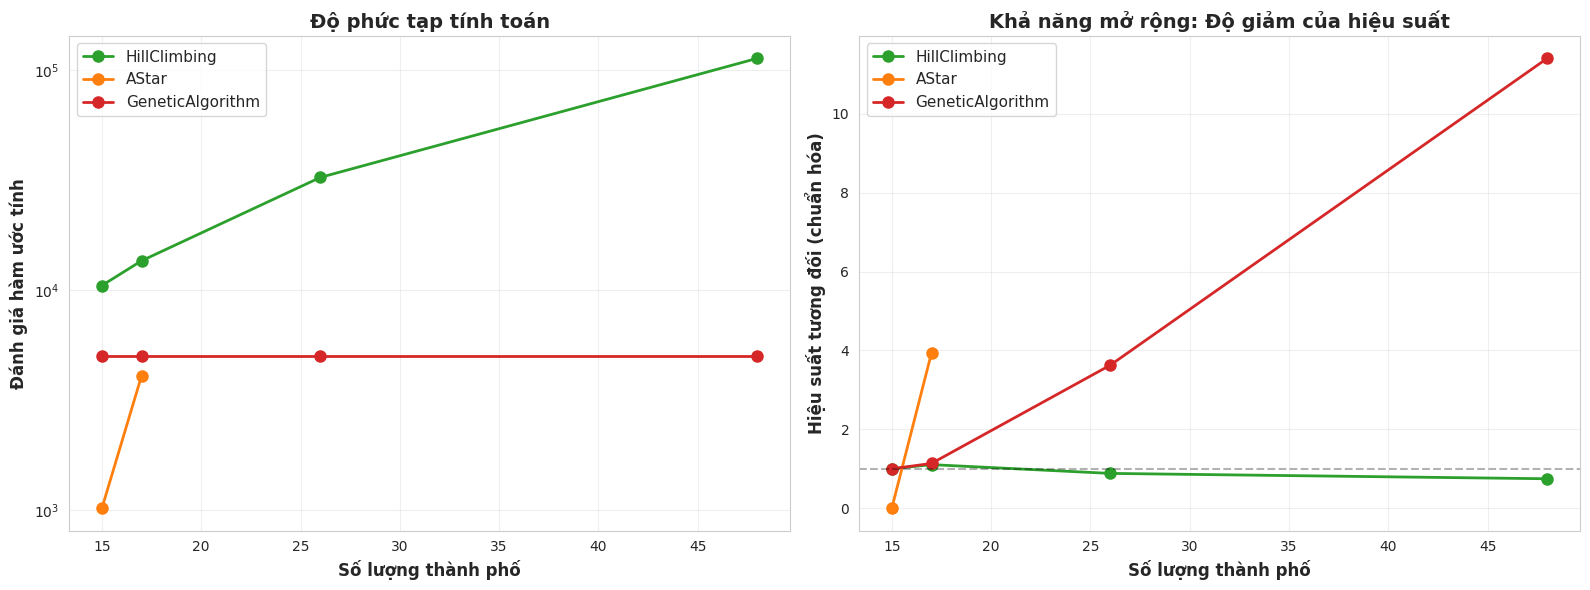


Average Metrics (excluding A* for large instances):
       Algorithm Avg Best Value Avg Time (s)
    HillClimbing        9281.25       0.0755
           AStar        1188.00      10.9615
GeneticAlgorithm       15840.75       0.1497


In [11]:
# Computational Complexity Analysis - Style from Ackley notebook
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

algorithms = ['HillClimbing', 'AStar', 'GeneticAlgorithm']

# Plot 1: Evaluations vs Problem Size  
ax1 = axes[0]
for algo in algorithms:
    problem_sizes = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['avg_time'] > 0:
            problem_sizes.append(statistics[test_name]['n_cities'])
    
    # Estimate evaluations based on algorithm characteristics
    # This is a proxy since we don't track exact evaluations
    if algo == 'HillClimbing':
        # HC: iterations * neighbors per iteration (approx n*(n-1) for TSP)
        evaluations = [n * (n-1) * 50 for n in problem_sizes]  # ~50 iterations avg
        ax1.plot(problem_sizes, evaluations, marker='o', label=algo, linewidth=2, markersize=8, color=colors[algo])
    elif algo == 'AStar':
        # A*: Exponential in worst case for TSP
        evaluations = [2**(n-5) if n <= 17 else 0 for n in problem_sizes]
        evaluations = [e for e in evaluations if e > 0]
        sizes_astar = [n for n in problem_sizes if n <= 17]
        if sizes_astar:
            ax1.plot(sizes_astar, evaluations, marker='o', label=algo, linewidth=2, markersize=8, color=colors[algo])
    elif algo == 'GeneticAlgorithm':
        # GA: generations * population_size
        evaluations = [100 * 50 for n in problem_sizes]  # 100 gen * 50 pop
        ax1.plot(problem_sizes, evaluations, marker='o', label=algo, linewidth=2, markersize=8, color=colors[algo])

ax1.set_xlabel('Số lượng thành phố', fontsize=12, fontweight='bold')
ax1.set_ylabel('Đánh giá hàm ước tính', fontsize=12, fontweight='bold')
ax1.set_title('Độ phức tạp tính toán', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Scalability Analysis - Performance Degradation
ax2 = axes[1]
for algo in algorithms:
    gaps = []
    problem_sizes = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['average'] != float('inf'):
            s = statistics[test_name][algo]
            if statistics[test_name]['optimal_distance']:
                gap = ((s['average'] - statistics[test_name]['optimal_distance']) / 
                       statistics[test_name]['optimal_distance'] * 100)
                gaps.append(gap)
                problem_sizes.append(statistics[test_name]['n_cities'])
    
    if gaps and len(gaps) > 1:
        # Normalize by first value to show degradation
        base_gap = gaps[0] if gaps[0] > 0 else 1
        normalized = [g / base_gap for g in gaps]
        ax2.plot(problem_sizes, normalized, marker='o', label=algo, linewidth=2, markersize=8, color=colors[algo])

ax2.set_xlabel('Số lượng thành phố', fontsize=12, fontweight='bold')
ax2.set_ylabel('Hiệu suất tương đối (chuẩn hóa)', fontsize=12, fontweight='bold')
ax2.set_title('Khả năng mở rộng: Độ giảm của hiệu suất', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAverage Metrics (excluding A* for large instances):")
avg_metrics_data = []
for algo in algorithms:
    best_vals = []
    times = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['best'] != float('inf'):
            best_vals.append(statistics[test_name][algo]['best'])
            times.append(statistics[test_name][algo]['avg_time'])
    
    if best_vals:
        avg_metrics_data.append({
            'Algorithm': algo,
            'Avg Best Value': f"{np.mean(best_vals):.2f}",
            'Avg Time (s)': f"{np.mean(times):.4f}"
        })

avg_df = pd.DataFrame(avg_metrics_data)
print(avg_df.to_string(index=False))

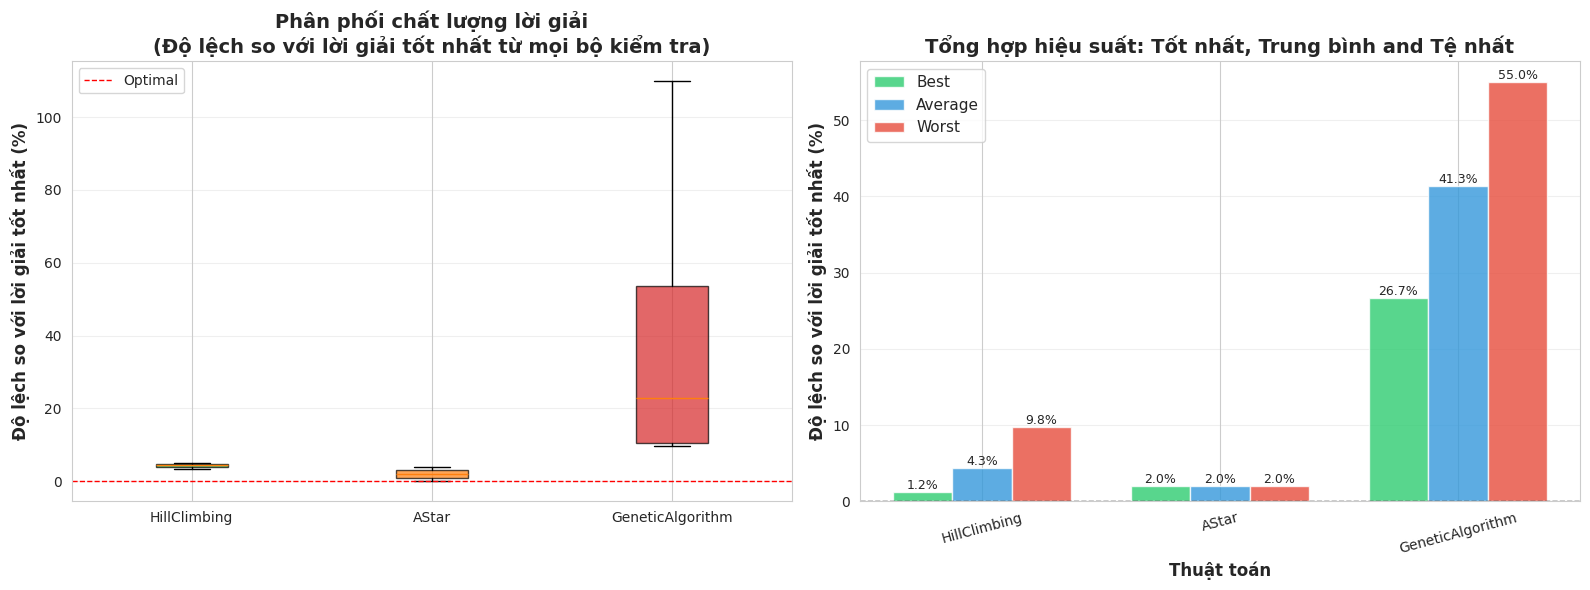


COMPREHENSIVE STATISTICAL SUMMARY - TSP ALGORITHMS
       Algorithm Best (mean) Best (std) Mean (mean) Mean (std) Avg Time (s) Time Std (s)
    HillClimbing     9281.25   14175.72     9523.27   14553.25       0.0755       0.1078
           AStar     1188.00     897.00     1188.00     897.00      10.9615       8.3923
GeneticAlgorithm    15840.75   25387.58    18547.32   29933.72       0.1497       0.0217


In [12]:
# Statistical Summary - Style from Ackley notebook
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

algorithms = ['HillClimbing', 'AStar', 'GeneticAlgorithm']

# Plot 1: Box plot for solution quality distribution
ax1 = axes[0]
box_data = []
labels = []

for algo in algorithms:
    gaps = []
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['average'] != float('inf'):
            s = statistics[test_name][algo]
            if statistics[test_name]['optimal_distance']:
                gap = ((s['average'] - statistics[test_name]['optimal_distance']) / 
                       statistics[test_name]['optimal_distance'] * 100)
                gaps.append(gap)
    
    if gaps:
        box_data.append(gaps)
        labels.append(algo)

if box_data:
    bp = ax1.boxplot(box_data, labels=labels, patch_artist=True)
    for patch, label in zip(bp['boxes'], labels):
        patch.set_facecolor(colors[label])
        patch.set_alpha(0.7)

ax1.set_ylabel('Độ lệch so với lời giải tốt nhất (%)', fontsize=12, fontweight='bold')
ax1.set_title('Phân phối chất lượng lời giải\n(Độ lệch so với lời giải tốt nhất từ mọi bộ kiểm tra)', 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=1, label='Optimal')
ax1.legend()

# Plot 2: Aggregated performance - Best, Mean, Worst
ax2 = axes[1]
aggregated_gaps_best = []
aggregated_gaps_avg = []
aggregated_gaps_worst = []
valid_algorithms = []

for algo in algorithms:
    gaps_best = []
    gaps_avg = []
    gaps_worst = []
    
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name]['optimal_distance']:
            s = statistics[test_name][algo]
            if s['best'] != float('inf'):
                gaps_best.append((s['best'] - statistics[test_name]['optimal_distance']) / 
                               statistics[test_name]['optimal_distance'] * 100)
            if s['average'] != float('inf'):
                gaps_avg.append((s['average'] - statistics[test_name]['optimal_distance']) / 
                              statistics[test_name]['optimal_distance'] * 100)
            if s['worst'] != float('inf'):
                gaps_worst.append((s['worst'] - statistics[test_name]['optimal_distance']) / 
                                statistics[test_name]['optimal_distance'] * 100)
    
    if gaps_best and gaps_avg and gaps_worst:
        aggregated_gaps_best.append(np.mean(gaps_best))
        aggregated_gaps_avg.append(np.mean(gaps_avg))
        aggregated_gaps_worst.append(np.mean(gaps_worst))
        valid_algorithms.append(algo)

if valid_algorithms:
    x_pos = np.arange(len(valid_algorithms))
    width = 0.25

    bars1 = ax2.bar(x_pos - width, aggregated_gaps_best, width, label='Best', alpha=0.8, color='#2ecc71')
    bars2 = ax2.bar(x_pos, aggregated_gaps_avg, width, label='Average', alpha=0.8, color='#3498db')
    bars3 = ax2.bar(x_pos + width, aggregated_gaps_worst, width, label='Worst', alpha=0.8, color='#e74c3c')

    ax2.set_ylabel('Độ lệch so với lời giải tốt nhất (%)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Thuật toán', fontsize=12, fontweight='bold')
    ax2.set_title('Tổng hợp hiệu suất: Tốt nhất, Trung bình and Tệ nhất', fontsize=14, fontweight='bold')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(valid_algorithms, rotation=15)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print comprehensive statistical summary
print("\n" + "=" * 100)
print("COMPREHENSIVE STATISTICAL SUMMARY - TSP ALGORITHMS")
print("=" * 100)

summary_data = []
for algo in algorithms:
    best_vals = []
    mean_vals = []
    std_vals = []
    times = []
    
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name][algo]['best'] != float('inf'):
            s = statistics[test_name][algo]
            best_vals.append(s['best'])
            mean_vals.append(s['average'])
            std_vals.append(s['std'])
            times.append(s['avg_time'])
    
    if best_vals:
        summary_data.append({
            'Algorithm': algo,
            'Best (mean)': f"{np.mean(best_vals):.2f}",
            'Best (std)': f"{np.std(best_vals):.2f}",
            'Mean (mean)': f"{np.mean(mean_vals):.2f}",
            'Mean (std)': f"{np.std(mean_vals):.2f}",
            'Avg Time (s)': f"{np.mean(times):.4f}",
            'Time Std (s)': f"{np.std(times):.4f}"
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

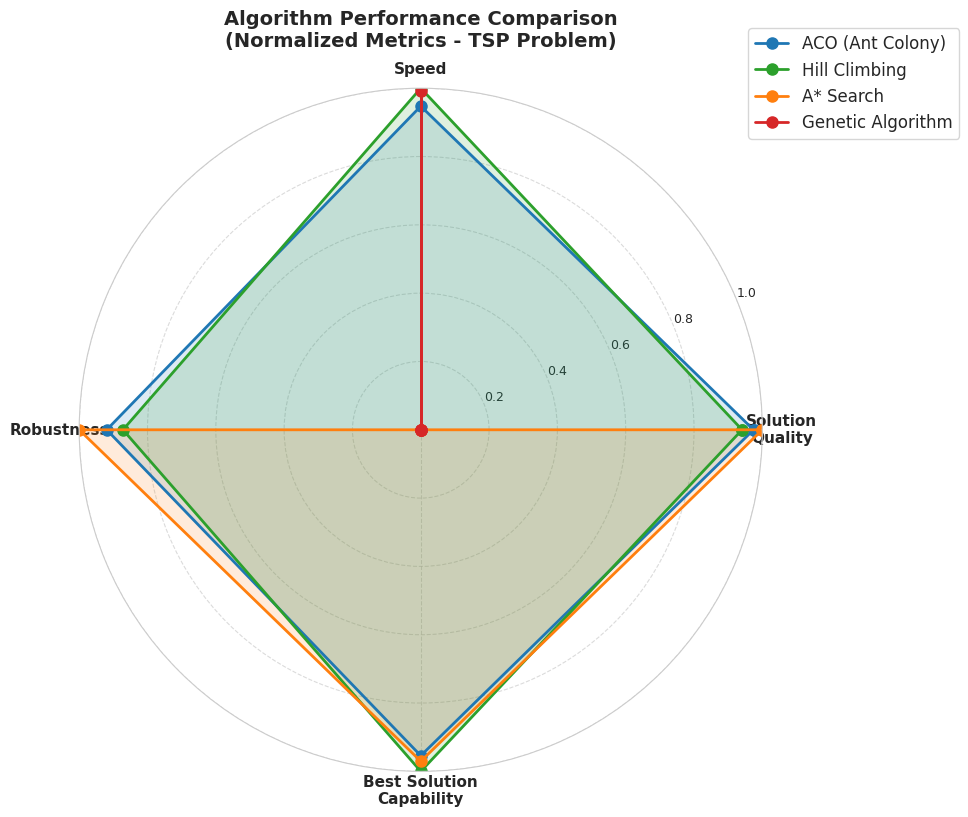


Metric Explanation:
- Solution Quality: Based on average gap from optimal (lower = better)
- Speed: Based on average execution time (faster = better)
- Robustness: Based on standard deviation (lower std = better)
- Best Solution Capability: Based on best solution gap (closer to optimal = better)

Values closer to 1.0 (outer edge) = Better performance

ALGORITHM RANKINGS (Lower rank = Better)
        Algorithm  Quality Rank  Speed Rank  Robustness Rank  Best Rank  Overall Rank
    Hill Climbing           3.0         1.0              3.0        1.0           2.0
        A* Search           1.0         4.0              1.0        2.0           2.0
 ACO (Ant Colony)           2.0         3.0              2.0        3.0           2.5
Genetic Algorithm           4.0         2.0              4.0        4.0           3.5


In [13]:
# Radar Chart for Overall Comparison - Style from Ackley notebook (INCLUDING ACO)
import matplotlib.pyplot as plt
from math import pi

def normalize_metric(values, higher_is_better=True):
    """Normalize metrics for radar chart"""
    min_val, max_val = min(values), max(values)
    if max_val == min_val:
        return [0.5] * len(values)
    normalized = [(v - min_val) / (max_val - min_val) for v in values]
    return normalized if higher_is_better else [1 - n for n in normalized]

# Prepare data for radar chart - NOW INCLUDING ACO
algorithms = ['ACO', 'HillClimbing', 'AStar', 'GeneticAlgorithm']
algo_names_display = {
    'ACO': 'ACO (Ant Colony)',
    'HillClimbing': 'Hill Climbing',
    'AStar': 'A* Search', 
    'GeneticAlgorithm': 'Genetic Algorithm'
}

radar_data = []
for algo in algorithms:
    gaps_avg = []
    times = []
    stds = []
    gaps_best = []
    
    for test_name in test_names:
        if algo in statistics[test_name] and statistics[test_name]['optimal_distance']:
            s = statistics[test_name][algo]
            if s['average'] != float('inf'):
                gap_avg = ((s['average'] - statistics[test_name]['optimal_distance']) / 
                          statistics[test_name]['optimal_distance'] * 100)
                gaps_avg.append(gap_avg)
                times.append(s['avg_time'])
                stds.append(s['std'])
                
                gap_best = ((s['best'] - statistics[test_name]['optimal_distance']) / 
                           statistics[test_name]['optimal_distance'] * 100)
                gaps_best.append(gap_best)
    
    if gaps_avg:
        radar_data.append({
            'algorithm': algo,
            'quality_avg': np.mean(gaps_avg),
            'speed': np.mean(times),
            'robustness': np.mean(stds),
            'best_capability': np.mean(gaps_best)
        })

# Extract metrics for normalization
all_quality = [d['quality_avg'] for d in radar_data]
all_speed = [d['speed'] for d in radar_data]
all_robustness = [d['robustness'] for d in radar_data]
all_best = [d['best_capability'] for d in radar_data]

# Create radar chart
categories = ['Solution\nQuality', 'Speed', 'Robustness', 'Best Solution\nCapability']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors_list = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']  # ACO, HC, A*, GA

for idx, data in enumerate(radar_data):
    algo = data['algorithm']
    
    # Normalize each metric (lower is better for all, so inverse=True)
    quality_score = normalize_metric(all_quality, False)[idx]
    speed_score = normalize_metric(all_speed, False)[idx]
    robustness_score = normalize_metric(all_robustness, False)[idx]
    best_score = normalize_metric(all_best, False)[idx]
    
    values = [quality_score, speed_score, robustness_score, best_score]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=algo_names_display[algo], 
            color=colors_list[idx], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=colors_list[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11, fontweight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=9)
ax.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
plt.title('Algorithm Performance Comparison\n(Normalized Metrics - TSP Problem)', 
          size=14, fontweight='bold', pad=30)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("Metric Explanation:")
print("=" * 80)
print("- Solution Quality: Based on average gap from optimal (lower = better)")
print("- Speed: Based on average execution time (faster = better)")
print("- Robustness: Based on standard deviation (lower std = better)")
print("- Best Solution Capability: Based on best solution gap (closer to optimal = better)")
print("\nValues closer to 1.0 (outer edge) = Better performance")
print("=" * 80)

# Print ranking
print("\n" + "=" * 80)
print("ALGORITHM RANKINGS (Lower rank = Better)")
print("=" * 80)

ranking_metrics = []
for data in radar_data:
    algo = data['algorithm']
    ranking_metrics.append({
        'Algorithm': algo_names_display[algo],
        'Avg Gap (%)': f"{data['quality_avg']:.2f}",
        'Avg Time (s)': f"{data['speed']:.4f}",
        'Avg Std': f"{data['robustness']:.2f}",
        'Best Gap (%)': f"{data['best_capability']:.2f}"
    })

ranking_df = pd.DataFrame(ranking_metrics)

# Add ranks
ranking_df['Quality Rank'] = ranking_df['Avg Gap (%)'].astype(float).rank(ascending=True)
ranking_df['Speed Rank'] = ranking_df['Avg Time (s)'].astype(float).rank(ascending=True)
ranking_df['Robustness Rank'] = ranking_df['Avg Std'].astype(float).rank(ascending=True)
ranking_df['Best Rank'] = ranking_df['Best Gap (%)'].astype(float).rank(ascending=True)
ranking_df['Overall Rank'] = (ranking_df['Quality Rank'] + ranking_df['Speed Rank'] + 
                               ranking_df['Robustness Rank'] + ranking_df['Best Rank']) / 4

ranking_df = ranking_df.sort_values('Overall Rank')
print(ranking_df[['Algorithm', 'Quality Rank', 'Speed Rank', 'Robustness Rank', 
                   'Best Rank', 'Overall Rank']].to_string(index=False))

## 7. Tổng kết và kết luận

In [14]:
print("\n" + "=" * 100)
print("TỔNG KẾT SO SÁNH CÁC THUẬT TOÁN")
print("=" * 100)

print(f"\nTổng số bộ kiểm tra đã đánh giá: {len(test_cases)}")
print(f"Số lần chạy cho mỗi thuật toán: {num_runs}")

print("\n" + "-" * 100)
print("CÁC PHÁT HIỆN CHÍNH:")
print("-" * 100)

if aggregated_stats['ACO']:
    print(f"\nACO (Tối ưu hóa Đàn kiến):")
    print(f"  - Chênh lệch trung bình so với tối ưu: {aggregated_stats['ACO']['gap_avg_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tốt nhất: {aggregated_stats['ACO']['gap_best_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tệ nhất: {aggregated_stats['ACO']['gap_worst_avg']:.2f}%")
    print(f"  - Thời gian chạy trung bình: {aggregated_stats['ACO']['avg_time']:.3f}s")

if aggregated_stats['HillClimbing']:
    print(f"\nHill Climbing (Leo đồi):")
    print(f"  - Chênh lệch trung bình so với tối ưu: {aggregated_stats['HillClimbing']['gap_avg_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tốt nhất: {aggregated_stats['HillClimbing']['gap_best_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tệ nhất: {aggregated_stats['HillClimbing']['gap_worst_avg']:.2f}%")
    print(f"  - Thời gian chạy trung bình: {aggregated_stats['HillClimbing']['avg_time']:.3f}s")

if aggregated_stats['GeneticAlgorithm']:
    print(f"\nGenetic Algorithm (Thuật toán di truyền):")
    print(f"  - Chênh lệch trung bình so với tối ưu: {aggregated_stats['GeneticAlgorithm']['gap_avg_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tốt nhất: {aggregated_stats['GeneticAlgorithm']['gap_best_avg']:.2f}%")
    print(f"  - Chênh lệch giải pháp tệ nhất: {aggregated_stats['GeneticAlgorithm']['gap_worst_avg']:.2f}%")
    print(f"  - Thời gian chạy trung bình: {aggregated_stats['GeneticAlgorithm']['avg_time']:.3f}s")

best_algo_by_quality = min(
    [(algo, aggregated_stats[algo]['gap_avg_avg']) 
     for algo in algorithms if aggregated_stats[algo]], 
    key=lambda x: x[1]
)

best_algo_by_speed = min(
    [(algo, aggregated_stats[algo]['avg_time']) 
     for algo in algorithms if aggregated_stats[algo]], 
    key=lambda x: x[1]
)

print("\n" + "-" * 100)
print("KHUYẾN NGHỊ:")
print("-" * 100)

print(f"\nTốt nhất về chất lượng giải pháp: {best_algo_by_quality[0]}")
print(f"  - Đạt {best_algo_by_quality[1]:.2f}% chênh lệch trung bình so với tối ưu")

print(f"\nTốt nhất về tốc độ: {best_algo_by_speed[0]}")
print(f"  - Thời gian chạy trung bình: {best_algo_by_speed[1]:.3f}s")

print("\n" + "-" * 100)
print("ĐặC ĐIểM CÁC THUẬT TOÁN:")
print("-" * 100)

characteristics = {
    'ACO': [
        'Trí tuệ đàn lấy cảm hứng từ hành vi kiếm ăn của kiến',
        'Cân bằng tốt giữa khai thác và thăm dò',
        'Vết mùi pheromone giúp thoát khỏi tối ưu cục bộ',
        'Phù hợp với các bài toán tối ưu động và phức tạp'
    ],
    'HillClimbing': [
        'Thuật toán tìm kiếm cục bộ đơn giản',
        'Hội tụ nhanh nhưng dễ rơi vào tối ưu cục bộ',
        'Hiệu suất phụ thuộc nhiều vào giải pháp ban đầu',
        'Tốt nhất cho các giải pháp xấp xỉ nhanh'
    ],
    'GeneticAlgorithm': [
        'Phương pháp tiến hóa dựa trên quần thể',
        'Duy trì tính đa dạng thông qua lai ghép và đột biến',
        'Khám phá không gian tìm kiếm tốt',
        'Có thể thoát khỏi tối ưu cục bộ hiệu quả'
    ]
}

for algo, chars in characteristics.items():
    print(f"\n{algo}:")
    for char in chars:
        print(f"  - {char}")

print("\n" + "=" * 100)


TỔNG KẾT SO SÁNH CÁC THUẬT TOÁN

Tổng số bộ kiểm tra đã đánh giá: 4
Số lần chạy cho mỗi thuật toán: 10

----------------------------------------------------------------------------------------------------
CÁC PHÁT HIỆN CHÍNH:
----------------------------------------------------------------------------------------------------

ACO (Tối ưu hóa Đàn kiến):
  - Chênh lệch trung bình so với tối ưu: 2.98%
  - Chênh lệch giải pháp tốt nhất: 2.38%
  - Chênh lệch giải pháp tệ nhất: 4.16%
  - Thời gian chạy trung bình: 0.648s

Hill Climbing (Leo đồi):
  - Chênh lệch trung bình so với tối ưu: 4.30%
  - Chênh lệch giải pháp tốt nhất: 1.21%
  - Chênh lệch giải pháp tệ nhất: 9.78%
  - Thời gian chạy trung bình: 0.075s

Genetic Algorithm (Thuật toán di truyền):
  - Chênh lệch trung bình so với tối ưu: 41.31%
  - Chênh lệch giải pháp tốt nhất: 26.70%
  - Chênh lệch giải pháp tệ nhất: 54.97%
  - Thời gian chạy trung bình: 0.150s

-------------------------------------------------------------------------